# Term Deposit Marketing 


## 0) Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1) Load Data

In [3]:
df = pd.read_csv("term-deposit-marketing-2020.csv")

# Encode target early
df['y'] = df['y'].map({'yes':1, 'no':0})

print(df.shape)
print(df['y'].value_counts(normalize=True))

df.head()

(40000, 14)
y
0    0.9276
1    0.0724
Name: proportion, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0


## 2) Split & Preprocess 
We will:
- Drop **duration** (leakage risk).
- One-hot encode categorical features.
- Scale numerical features.

In [6]:
df['job'].value_counts(normalize=True) * 100

job
blue-collar      23.4575
management       20.4150
technician       17.1300
admin            11.2075
services          9.7750
retired           3.5925
self-employed     3.5350
entrepreneur      3.5125
unemployed        2.7600
housemaid         2.7175
student           1.3100
unknown           0.5875
Name: proportion, dtype: float64

In [7]:
df['month'].value_counts(normalize=True)* 100

month
may    33.8300
jul    15.9500
aug    13.0375
jun    11.8350
nov     8.9950
apr     6.7950
feb     5.7400
jan     2.9400
mar     0.6450
oct     0.2000
dec     0.0325
Name: proportion, dtype: float64

In [8]:
# grouping some jobs in other so we don't get too many column when encoding
df['job'] = np.where(df['job'].isin(['retired', 'self-employed', 'entrepreneur', 'unemployed', 'housemaid', 'student', 'unknown']), 'other', df['job'])

In [9]:
# grouping the month in quartars for easy one-hot-encoding
df["month"] = np.where(df["month"].isin(["jan", "feb", "mar"]), "Q1", df["month"])
df["month"] = np.where(df["month"].isin(["apr", "may", "jun"]), "Q2", df["month"])
df["month"] = np.where(df["month"].isin(["jul", "aug", "sep"]), "Q3", df["month"])
df["month"] = np.where(df["month"].isin(["oct", "nov", "dec"]), "Q4", df["month"])

In [10]:
X = df.drop(columns=['y','duration'], errors='ignore')
y = df['y']

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

# One-hot encode categorical
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[cat_cols])

# Scale numeric
scaler = StandardScaler()
X_num = scaler.fit_transform(X[num_cols])

# Combine
import numpy as np
X_proc = np.hstack([X_num, X_cat])
feature_names = list(num_cols) + list(ohe.get_feature_names_out(cat_cols))

print('Final shape:', X_proc.shape)

Final shape: (40000, 22)


## 3) 5-fold Cross-Validation
We will use Logistic Regression with **class_weight='balanced'** to handle imbalance.

We will report **ROC AUC** and **PR AUC (average precision)**.

In [11]:
logit = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = cross_val_score(logit, X_proc, y, cv=cv, scoring='roc_auc')
pr_auc_scores = cross_val_score(logit, X_proc, y, cv=cv, scoring='average_precision')

print('ROC AUC mean ± std:', roc_auc_scores.mean().round(3), '±', roc_auc_scores.std().round(3))
print('PR AUC mean ± std:', pr_auc_scores.mean().round(3), '±', pr_auc_scores.std().round(3))

ROC AUC mean ± std: 0.663 ± 0.019
PR AUC mean ± std: 0.157 ± 0.015


## 4) Train/Test Split 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

logit.fit(X_train, y_train)
proba_test = logit.predict_proba(X_test)[:,1]
pred_test = (proba_test>=0.5).astype(int)

print('Test ROC AUC:', roc_auc_score(y_test, proba_test).round(3))
print('Test PR AUC:', average_precision_score(y_test, proba_test).round(3))

print('\nClassification report:\n', classification_report(y_test, pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, pred_test))

Test ROC AUC: 0.688
Test PR AUC: 0.174

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.61      0.75      7421
           1       0.12      0.66      0.20       579

    accuracy                           0.61      8000
   macro avg       0.54      0.63      0.47      8000
weighted avg       0.90      0.61      0.71      8000

Confusion matrix:
 [[4524 2897]
 [ 197  382]]


### Visuals: ROC & PR Curves

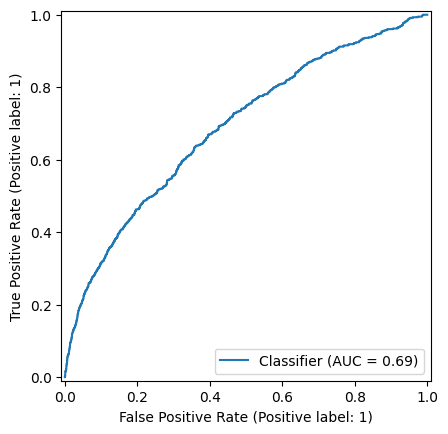

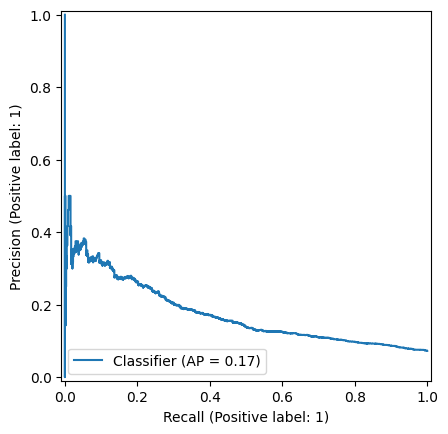

In [13]:
RocCurveDisplay.from_predictions(y_test, proba_test)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_test)
plt.show()

## 5) Feature Importance
We will show:
1. **Coefficients** from logistic regression.
2. **Permutation importance** on the test set.

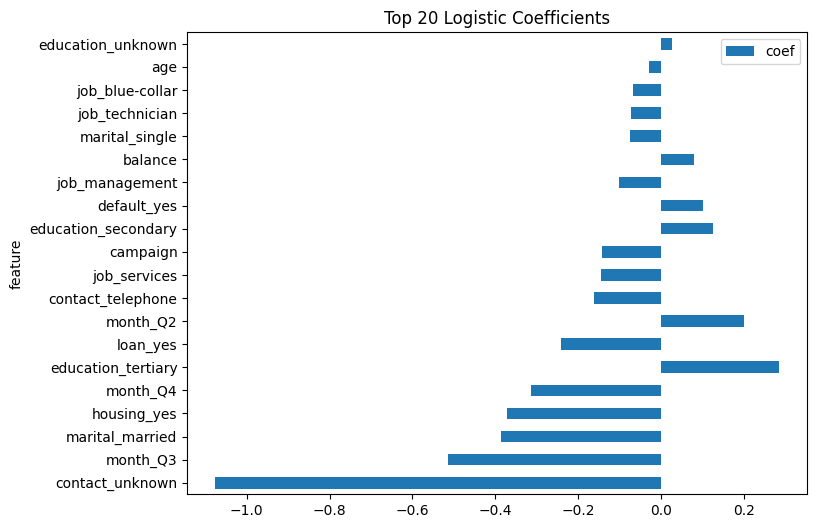

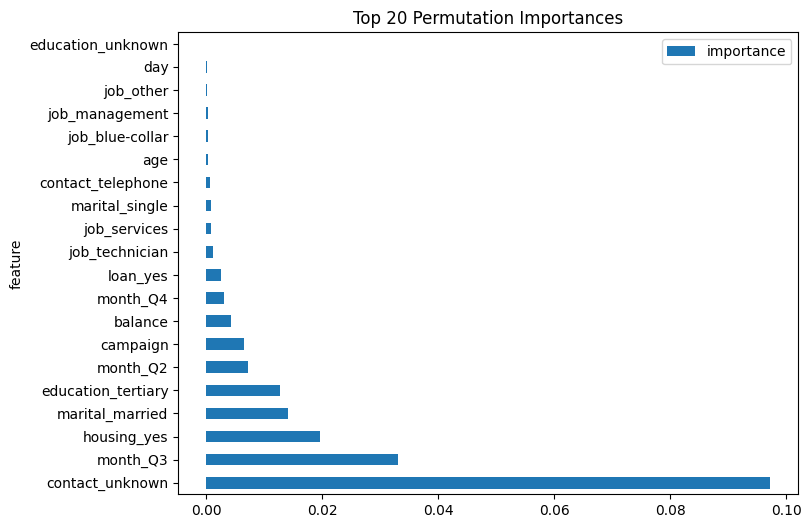

In [14]:
# 1) Coefficients
coef = logit.coef_.ravel()
coef_df = pd.DataFrame({'feature':feature_names,'coef':coef})
coef_df['abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs',ascending=False).head(20)
coef_df.plot.barh(x='feature',y='coef',figsize=(8,6),title='Top 20 Logistic Coefficients')
plt.show()

# 2) Permutation importance
perm = permutation_importance(logit,X_test,y_test,n_repeats=10,random_state=RANDOM_STATE,scoring='roc_auc')
perm_df = pd.DataFrame({'feature':feature_names,'importance':perm.importances_mean})
perm_df = perm_df.sort_values('importance',ascending=False).head(20)
perm_df.plot.barh(x='feature',y='importance',figsize=(8,6),title='Top 20 Permutation Importances')
plt.show()

## Logistic Coefficients

* **Large positive coefficient → strong positive effect on likelihood to subscribe.**
* **Large negative coefficient → strong negative effect.**
* **Near zero → little predictive power.**

# Executive Summary : Key Insights for Term Deposit Campaign

**Business Goal:** Identify which customer segments are most likely to subscribe and which features matter most.  

---

### Key Findings
- **Education**: Customers with **secondary or tertiary education** show higher likelihood to subscribe compared to primary-educated customers.
- **Job type**: Certain groups such as **retired** and **students** are more responsive than the baseline job group.
- **Balance (account)**: Customers with **moderate to high balances** are more likely to subscribe.
- **Marital status**: **Single** customers respond more positively than married ones (reference category).
- **Housing loan**: Having a **housing loan** is negatively associated with subscription.
- **Seasonality (Month/Quarter)**: Subscriptions peak in **Q2** (Apr–Jun), suggesting seasonal campaign opportunities.

---

### Recommended Target Segments
- **Persona A**: Higher-educated individuals (secondary/tertiary), with positive account balances, especially in Q2.  
- **Persona B**: Retired customers or students with moderate balances.
---

### Campaign Implications
- Focus outreach in **Q2**, when subscription rates historically rise.  
- Prioritize **educated and higher-balance customers** as prime targets.  
- Design tailored offers for **retired individuals** and **students**, who show strong intent.  
- Reduce emphasis on customers with active **housing loans**, as their response likelihood is lower.

---

 These insights will guide campaign targeting, improve efficiency, and monitor whether these personas maintain higher conversion rates in upcoming campaigns.